In [24]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ttest_1samp
from pandas.tseries.offsets import MonthBegin
from urllib.request import urlopen
from zipfile import ZipFile
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt


In [2]:
df_monthly_crsp = pd.read_csv('/Users/global_minima/Downloads/crsp_monthly.csv')

In [3]:
df_monthly_crsp

,PERMNO,date,SHRCD,COMNAM,DLRET,PRC,RET,SHROUT
0,10000,19851231,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,19860131,10.0,OPTIMUM MANUFACTURING INC,NaN,-4.37500,C,3680.0
2,10000,19860228,10.0,OPTIMUM MANUFACTURING INC,NaN,-3.25000,-0.257143,3680.0
3,10000,19860331,10.0,OPTIMUM MANUFACTURING INC,NaN,-4.43750,0.365385,3680.0
4,10000,19860430,10.0,OPTIMUM MANUFACTURING INC,NaN,-4.00000,-0.098592,3793.0
...,...,...,...,...,...,...,...,...
4839132,93436,20211130,11.0,TESLA INC,NaN,1144.76001,0.027612,1004265.0
4839133,93436,20211231,11.0,TESLA INC,NaN,1056.78003,-0.076855,1033534.0
4839134,93436,20220131,11.0,TESLA INC,NaN,936.71997,-0.113609,1033534.0
4839135,93436,20220228,11.0,TESLA INC,NaN,870.42999,-0.070768,1033534.0


In [4]:
shrd_code = [10.0, 11.0]
df_monthly_crsp = df_monthly_crsp.loc[(df_monthly_crsp['SHRCD'].isin(shrd_code))]

In [5]:
df_monthly_crsp.columns = df_monthly_crsp.columns.str.lower()

In [6]:
df_monthly_crsp['date'] = df_monthly_crsp['date'].apply(str)
df_monthly_crsp["date"] = pd.to_datetime(df_monthly_crsp["date"])
df_monthly_crsp['ret'] = pd.to_numeric(df_monthly_crsp['ret'], errors = 'coerce')
df_monthly_crsp['dlret'] = pd.to_numeric(df_monthly_crsp['dlret'], errors = 'coerce')
df_monthly_crsp["prc"] = abs(df_monthly_crsp["prc"])
df_monthly_crsp["ret"].fillna(df_monthly_crsp.dlret, inplace=True)
df_monthly_crsp = df_monthly_crsp[df_monthly_crsp['ret'].notna()]

#### Part 0.2

In [7]:
df_monthly_crsp.sort_values(['permno', 'date'], inplace=True)

df_monthly_crsp['ret_1'] = df_monthly_crsp['ret'] +1
df_monthly_crsp['ret_p_12m'] = df_monthly_crsp.groupby('permno')['ret_1'].shift(1).rolling(12).apply(lambda x : x.prod())-1

In [8]:
df_monthly_crsp

,permno,date,shrcd,comnam,dlret,prc,ret,shrout,ret_1,ret_p_12m
2,10000,1986-02-28,10.0,OPTIMUM MANUFACTURING INC,NaN,3.25000,-0.257143,3680.0,0.742857,NaN
3,10000,1986-03-31,10.0,OPTIMUM MANUFACTURING INC,NaN,4.43750,0.365385,3680.0,1.365385,NaN
4,10000,1986-04-30,10.0,OPTIMUM MANUFACTURING INC,NaN,4.00000,-0.098592,3793.0,0.901408,NaN
5,10000,1986-05-30,10.0,OPTIMUM MANUFACTURING INC,NaN,3.10938,-0.222656,3793.0,0.777344,NaN
6,10000,1986-06-30,10.0,OPTIMUM MANUFACTURING INC,NaN,3.09375,-0.005025,3793.0,0.994975,NaN
...,...,...,...,...,...,...,...,...,...,...
4839132,93436,2021-11-30,11.0,TESLA INC,NaN,1144.76001,0.027612,1004265.0,1.027612,1.870836
4839133,93436,2021-12-31,11.0,TESLA INC,NaN,1056.78003,-0.076855,1033534.0,0.923145,1.016841
4839134,93436,2022-01-31,11.0,TESLA INC,NaN,936.71997,-0.113609,1033534.0,0.886391,0.497554
4839135,93436,2022-02-28,11.0,TESLA INC,NaN,870.42999,-0.070768,1033534.0,0.929232,0.180446


In [9]:
df_monthly_crsp['ret_f_1m'] = df_monthly_crsp.groupby('permno')['ret_1'].shift(-1)-1
df_monthly_crsp['ret_f_3m'] = df_monthly_crsp.groupby('permno')['ret_1'].rolling(3).apply(lambda x : x.prod()).reset_index(level = 0, drop = True)
df_monthly_crsp['ret_f_6m'] = df_monthly_crsp.groupby('permno')['ret_1'].rolling(6).apply(lambda x : x.prod()).reset_index(level = 0, drop = True)
df_monthly_crsp['ret_f_12m'] = df_monthly_crsp.groupby('permno')['ret_1'].rolling(12).apply(lambda x : x.prod()).reset_index(level = 0, drop = True)
df_monthly_crsp['ret_f_60m'] = df_monthly_crsp.groupby('permno')['ret_1'].rolling(60).apply(lambda x : x.prod()).reset_index(level = 0, drop = True)

df_monthly_crsp['ret_f_3m'] = df_monthly_crsp['ret_f_3m'].shift(-3)-1
df_monthly_crsp['ret_f_6m'] = df_monthly_crsp['ret_f_6m'].shift(-6)-1
df_monthly_crsp['ret_f_12m'] = df_monthly_crsp['ret_f_12m'].shift(-12)-1
df_monthly_crsp['ret_f_60m'] = df_monthly_crsp['ret_f_60m'].shift(-60)-1

In [10]:
x = df_monthly_crsp[df_monthly_crsp['permno'] == 93436]
x.to_csv('perm_1_m.csv')

In [11]:
df_monthly_crsp = df_monthly_crsp[df_monthly_crsp['prc'] >5]

In [12]:
df_monthly_crsp

,permno,date,shrcd,comnam,dlret,prc,ret,shrout,ret_1,ret_p_12m,ret_f_1m,ret_f_3m,ret_f_6m,ret_f_12m,ret_f_60m
21,10001,1986-02-28,11.0,GREAT FALLS GAS CO,NaN,6.25000,0.020408,985.0,1.020408,NaN,0.025200,0.025200,0.073749,0.065199,1.141632
22,10001,1986-03-31,11.0,GREAT FALLS GAS CO,NaN,6.31250,0.025200,985.0,1.025200,NaN,0.009901,-0.013069,0.044133,0.077251,1.064887
23,10001,1986-04-30,11.0,GREAT FALLS GAS CO,NaN,6.37500,0.009901,985.0,1.009901,NaN,-0.009804,-0.032717,0.074441,0.024858,1.125353
24,10001,1986-05-30,11.0,GREAT FALLS GAS CO,NaN,6.31250,-0.009804,985.0,0.990196,NaN,-0.013069,0.047355,0.146499,-0.038924,1.146397
25,10001,1986-06-30,11.0,GREAT FALLS GAS CO,NaN,6.12500,-0.013069,985.0,0.986931,NaN,-0.010204,0.057959,0.179107,0.023885,1.345501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4839132,93436,2021-11-30,11.0,TESLA INC,NaN,1144.76001,0.027612,1004265.0,1.027612,1.870836,-0.076855,-0.239640,NaN,NaN,NaN
4839133,93436,2021-12-31,11.0,TESLA INC,NaN,1056.78003,-0.076855,1033534.0,0.923145,1.016841,-0.113609,0.019702,NaN,NaN,NaN
4839134,93436,2022-01-31,11.0,TESLA INC,NaN,936.71997,-0.113609,1033534.0,0.886391,0.497554,-0.070768,NaN,NaN,NaN,NaN
4839135,93436,2022-02-28,11.0,TESLA INC,NaN,870.42999,-0.070768,1033534.0,0.929232,0.180446,0.238009,NaN,NaN,NaN,NaN


In [13]:
df_monthly_crsp = df_monthly_crsp[df_monthly_crsp['ret_p_12m'].notna()]
df_monthly_crsp['decile']  = df_monthly_crsp.groupby('date')['ret_p_12m'].apply(lambda x: pd.qcut(x, 10, labels = False))

In [14]:
df_monthly_crsp

,permno,date,shrcd,comnam,dlret,prc,ret,shrout,ret_1,ret_p_12m,ret_f_1m,ret_f_3m,ret_f_6m,ret_f_12m,ret_f_60m,decile
33,10001,1987-02-27,11.0,GREAT FALLS GAS CO,NaN,6.25000,-0.074074,991.0,0.925926,0.173892,0.036800,-0.075012,0.076022,0.156487,1.388918,4
34,10001,1987-03-31,11.0,GREAT FALLS GAS CO,NaN,6.37500,0.036800,991.0,1.036800,0.065199,-0.039216,-0.061961,0.014678,0.030335,1.492645,3
35,10001,1987-04-30,11.0,GREAT FALLS GAS CO,NaN,6.12500,-0.039216,991.0,0.960784,0.077251,-0.071429,-0.002900,0.077216,0.105218,1.621985,4
36,10001,1987-05-29,11.0,GREAT FALLS GAS CO,NaN,5.68750,-0.071429,991.0,0.928571,0.024858,0.051429,0.163283,0.125959,0.213804,1.853400,4
37,10001,1987-06-30,11.0,GREAT FALLS GAS CO,NaN,5.87500,0.051429,991.0,1.051429,-0.038924,0.021277,0.081702,0.034972,0.140535,1.692912,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4839132,93436,2021-11-30,11.0,TESLA INC,NaN,1144.76001,0.027612,1004265.0,1.027612,1.870836,-0.076855,-0.239640,NaN,NaN,NaN,9
4839133,93436,2021-12-31,11.0,TESLA INC,NaN,1056.78003,-0.076855,1033534.0,0.923145,1.016841,-0.113609,0.019702,NaN,NaN,NaN,9
4839134,93436,2022-01-31,11.0,TESLA INC,NaN,936.71997,-0.113609,1033534.0,0.886391,0.497554,-0.070768,NaN,NaN,NaN,NaN,7
4839135,93436,2022-02-28,11.0,TESLA INC,NaN,870.42999,-0.070768,1033534.0,0.929232,0.180446,0.238009,NaN,NaN,NaN,NaN,5


In [15]:
df_monthly_crsp['up_down_decile'] = np.where(df_monthly_crsp['decile'] ==9 , 'UP', 'NONE')
df_monthly_crsp.loc[df_monthly_crsp['decile']==0, 'up_down_decile']='DOWN'
# df_monthly_crsp['up_down_decile'] = np.where(df_monthly_crsp['decile'] ==0 , 'DOWN')

In [16]:
up_portfolio = df_monthly_crsp[df_monthly_crsp['decile'] == 9]
down_portfolio = df_monthly_crsp[df_monthly_crsp['decile'] == 0 ]

In [17]:
up_portfolio

,permno,date,shrcd,comnam,dlret,prc,ret,shrout,ret_1,ret_p_12m,ret_f_1m,ret_f_3m,ret_f_6m,ret_f_12m,ret_f_60m,decile,up_down_decile
69,10001,1990-02-28,11.0,GREAT FALLS GAS CO,NaN,9.87500,-0.006289,1022.0,0.993711,0.624808,0.012658,-0.000160,-0.012058,0.043121,0.940904,9,UP
257,10001,2005-10-31,11.0,ENERGY WEST INC,NaN,10.09990,-0.119036,2913.0,0.880964,0.886883,-0.059397,-0.055436,-0.009651,0.121417,1.140472,9,UP
258,10001,2005-11-30,11.0,ENERGY WEST INC,NaN,9.50000,-0.059397,2914.0,0.940603,0.760397,0.021053,-0.006371,0.041883,0.253565,1.006120,9,UP
274,10001,2007-03-30,11.0,ENERGY WEST INC,NaN,14.47000,0.019732,3002.0,1.019732,0.567975,0.002764,0.047000,-0.017915,-0.024958,0.563981,9,UP
278,10001,2007-07-31,11.0,ENERGY WEST INC,NaN,14.15000,-0.056667,2859.0,0.943333,0.728571,0.027562,-0.045685,0.019800,0.133623,0.402213,9,UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4839126,93436,2021-05-28,11.0,TESLA INC,NaN,625.21997,-0.118713,963330.0,0.881287,3.536761,0.087137,0.176737,0.830969,NaN,NaN,9,UP
4839127,93436,2021-06-30,11.0,TESLA INC,NaN,679.70001,0.087137,984003.0,1.087137,2.743836,0.011034,0.140914,0.554772,NaN,NaN,9,UP
4839128,93436,2021-07-30,11.0,TESLA INC,NaN,687.20001,0.011034,990015.0,1.011034,2.147314,0.070605,0.621070,0.363096,NaN,NaN,9,UP
4839132,93436,2021-11-30,11.0,TESLA INC,NaN,1144.76001,0.027612,1004265.0,1.027612,1.870836,-0.076855,-0.239640,NaN,NaN,NaN,9,UP


In [18]:
up_portfolio.columns

Index(['permno', 'date', 'shrcd', 'comnam', 'dlret', 'prc', 'ret', 'shrout',
       'ret_1', 'ret_p_12m', 'ret_f_1m', 'ret_f_3m', 'ret_f_6m', 'ret_f_12m',
       'ret_f_60m', 'decile', 'up_down_decile'],
      dtype='object')

In [19]:
up_portfolio_return = up_portfolio[['date','ret_f_1m', 'ret_f_3m', 'ret_f_6m', 'ret_f_12m',
       'ret_f_60m']].groupby('date').mean()

down_portfolio_return = down_portfolio[['date','ret_f_1m', 'ret_f_3m', 'ret_f_6m', 'ret_f_12m',
       'ret_f_60m']].groupby('date').mean()
difference_portfolio_return = up_portfolio_return - down_portfolio_return

up_portfolio_return = up_portfolio_return.rename(columns={'date':'date',"ret_f_1m" : "UP_ret_f_1m", "ret_f_3m":"UP_ret_f_3m"
                              , "ret_f_6m":"UP_ret_f_6m", "ret_f_12m":"UP_ret_f_12m", "ret_f_60m":"UP_ret_f_60m"})



down_portfolio_return = down_portfolio_return.rename(columns={"ret_f_1m" : "DOWN_ret_f_1m", "ret_f_3m":"DOWN_ret_f_3m"
                              , "ret_f_6m":"DOWN_ret_f_6m", "ret_f_12m":"DOWN_ret_f_12m", "ret_f_60m":"DOWN_ret_f_60m"})
# difference_portfolio = up_portfolio_ret - down_portfolio_ret
difference_portfolio_return = difference_portfolio_return.rename(columns={"ret_f_1m" : "UMD_ret_f_1m", "ret_f_3m":"UMD_ret_f_3m"
                              , "ret_f_6m":"UMD_ret_f_6m", "ret_f_12m":"UMD_ret_f_12m", "ret_f_60m":"UMD_ret_f_60m"})


In [20]:
difference_portfolio_return

,UMD_ret_f_1m,UMD_ret_f_3m,UMD_ret_f_6m,UMD_ret_f_12m,UMD_ret_f_60m
date,,,,,
1927-01-31,-0.006260,0.043860,0.073676,-0.095674,0.298734
1927-02-28,0.038686,0.117734,0.073401,-0.038266,0.223819
1927-03-31,0.041817,0.122118,0.090597,-0.101796,0.059674
1927-04-30,0.074389,0.106399,0.060581,-0.273753,0.039473
1927-05-31,0.005362,0.026063,-0.015952,-0.420278,-0.026366
...,...,...,...,...,...
2021-11-30,-0.001599,0.104031,NaN,NaN,NaN
2021-12-31,0.023337,0.125713,NaN,NaN,NaN
2022-01-31,0.086566,NaN,NaN,NaN,NaN


In [21]:
merged_portfolio = pd.merge(up_portfolio_return,down_portfolio_return, how = 'inner', on = 'date' )
merged_portfolio = merged_portfolio.merge(difference_portfolio_return, how = 'inner', on = 'date')

In [22]:
merged_portfolio

,UP_ret_f_1m,UP_ret_f_3m,UP_ret_f_6m,UP_ret_f_12m,UP_ret_f_60m,DOWN_ret_f_1m,DOWN_ret_f_3m,DOWN_ret_f_6m,DOWN_ret_f_12m,DOWN_ret_f_60m,UMD_ret_f_1m,UMD_ret_f_3m,UMD_ret_f_6m,UMD_ret_f_12m,UMD_ret_f_60m
date,,,,,,,,,,,,,,,
1927-01-31,0.049676,0.082084,0.226011,0.480389,-0.411871,0.055936,0.038224,0.152335,0.576063,-0.710605,-0.006260,0.043860,0.073676,-0.095674,0.298734
1927-02-28,0.002539,0.136222,0.206293,0.305895,-0.495423,-0.036147,0.018489,0.132892,0.344162,-0.719243,0.038686,0.117734,0.073401,-0.038266,0.223819
1927-03-31,0.051270,0.124750,0.273592,0.370485,-0.671427,0.009454,0.002632,0.182995,0.472281,-0.731101,0.041817,0.122118,0.090597,-0.101796,0.059674
1927-04-30,0.106248,0.179800,0.156788,0.369972,-0.721288,0.031859,0.073400,0.096207,0.643725,-0.760760,0.074389,0.106399,0.060581,-0.273753,0.039473
1927-05-31,-0.034065,0.047730,0.114398,0.223713,-0.763902,-0.039427,0.021667,0.130349,0.643991,-0.737536,0.005362,0.026063,-0.015952,-0.420278,-0.026366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,-0.016266,-0.074296,NaN,NaN,NaN,-0.014667,-0.178327,NaN,NaN,NaN,-0.001599,0.104031,NaN,NaN,NaN
2021-12-31,-0.122365,-0.058502,NaN,NaN,NaN,-0.145702,-0.184215,NaN,NaN,NaN,0.023337,0.125713,NaN,NaN,NaN
2022-01-31,0.037033,NaN,NaN,NaN,NaN,-0.049533,NaN,NaN,NaN,NaN,0.086566,NaN,NaN,NaN,NaN


#### Part 2.1

In [23]:
merged_portfolio

,UP_ret_f_1m,UP_ret_f_3m,UP_ret_f_6m,UP_ret_f_12m,UP_ret_f_60m,DOWN_ret_f_1m,DOWN_ret_f_3m,DOWN_ret_f_6m,DOWN_ret_f_12m,DOWN_ret_f_60m,UMD_ret_f_1m,UMD_ret_f_3m,UMD_ret_f_6m,UMD_ret_f_12m,UMD_ret_f_60m
date,,,,,,,,,,,,,,,
1927-01-31,0.049676,0.082084,0.226011,0.480389,-0.411871,0.055936,0.038224,0.152335,0.576063,-0.710605,-0.006260,0.043860,0.073676,-0.095674,0.298734
1927-02-28,0.002539,0.136222,0.206293,0.305895,-0.495423,-0.036147,0.018489,0.132892,0.344162,-0.719243,0.038686,0.117734,0.073401,-0.038266,0.223819
1927-03-31,0.051270,0.124750,0.273592,0.370485,-0.671427,0.009454,0.002632,0.182995,0.472281,-0.731101,0.041817,0.122118,0.090597,-0.101796,0.059674
1927-04-30,0.106248,0.179800,0.156788,0.369972,-0.721288,0.031859,0.073400,0.096207,0.643725,-0.760760,0.074389,0.106399,0.060581,-0.273753,0.039473
1927-05-31,-0.034065,0.047730,0.114398,0.223713,-0.763902,-0.039427,0.021667,0.130349,0.643991,-0.737536,0.005362,0.026063,-0.015952,-0.420278,-0.026366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,-0.016266,-0.074296,NaN,NaN,NaN,-0.014667,-0.178327,NaN,NaN,NaN,-0.001599,0.104031,NaN,NaN,NaN
2021-12-31,-0.122365,-0.058502,NaN,NaN,NaN,-0.145702,-0.184215,NaN,NaN,NaN,0.023337,0.125713,NaN,NaN,NaN
2022-01-31,0.037033,NaN,NaN,NaN,NaN,-0.049533,NaN,NaN,NaN,NaN,0.086566,NaN,NaN,NaN,NaN


In [27]:
t_stats = merged_portfolio[merged_portfolio.columns].apply(lambda x: ttest_1samp(x, popmean=0, nan_policy ="omit"))
t_stats = t_stats.rename(index ={0:'t_statisitc', 1:'p_value'})

In [28]:
t_stats

,UP_ret_f_1m,UP_ret_f_3m,UP_ret_f_6m,UP_ret_f_12m,UP_ret_f_60m,DOWN_ret_f_1m,DOWN_ret_f_3m,DOWN_ret_f_6m,DOWN_ret_f_12m,DOWN_ret_f_60m,UMD_ret_f_1m,UMD_ret_f_3m,UMD_ret_f_6m,UMD_ret_f_12m,UMD_ret_f_60m
t_statisitc,7.596623e+00,1.122251e+01,1.429539e+01,1.700251e+01,3.062293e+01,1.340632,3.006007,5.566937e+00,1.064867e+01,3.400065e+01,7.061857e+00,9.720720e+00,1.251628e+01,7.785522e+00,-4.804730
p_value,6.310264e-14,8.498075e-28,9.294917e-43,6.274234e-58,2.612681e-149,0.180307,0.002705,3.232747e-08,2.666427e-25,5.249259e-173,2.849719e-12,1.638070e-21,9.126096e-34,1.560860e-14,0.000002


In [33]:
zipurl = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip'
zipresp = urlopen(zipurl)
tempzip = open("/tmp/tempfile.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
zf = ZipFile("/tmp/tempfile.zip")
zf.extractall()
zf.close()
factor_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv' , 
                          skiprows=3, header=0, names =['date','mkt_rf', 'smb', 'hml', 'rmw', 'cma', 'rf'])

factor_data['date'] = factor_data['date'].str.strip()
factor_data= factor_data.loc[factor_data['date'].str.len()==6]
factor_data['date'] = factor_data['date']+'01'
factor_data["date"] = pd.to_datetime(factor_data["date"], format="%Y%m%d")
cols = factor_data.columns.drop('date')
factor_data[cols] = factor_data[cols].apply(pd.to_numeric, errors='coerce')/100

In [39]:
data_for_regression  = merged_portfolio.reset_index()
data_for_regression = data_for_regression[['date','UP_ret_f_1m', 'DOWN_ret_f_1m', 'UMD_ret_f_1m']]

In [42]:
data_for_regression['date'] = pd.to_datetime(data_for_regression['date']) - MonthBegin()

In [44]:
data_for_regression = pd.merge(data_for_regression, factor_data, how = "inner", on = 'date')

In [45]:
data_for_regression

,date,UP_ret_f_1m,DOWN_ret_f_1m,UMD_ret_f_1m,mkt_rf,smb,hml,rmw,cma,rf
0,1963-07-01,0.089905,0.052989,0.036916,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1,1963-08-01,-0.020096,-0.024147,0.004051,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
2,1963-09-01,0.028606,0.010505,0.018101,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
3,1963-10-01,-0.011524,-0.026724,0.015200,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
4,1963-11-01,0.003267,-0.028799,0.032066,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
...,...,...,...,...,...,...,...,...,...,...
700,2021-11-01,-0.016266,-0.014667,-0.001599,-0.0155,-0.0176,-0.0044,0.0722,0.0174,0.0000
701,2021-12-01,-0.122365,-0.145702,0.023337,0.0310,-0.0077,0.0328,0.0492,0.0443,0.0001
702,2022-01-01,0.037033,-0.049533,0.086566,-0.0625,-0.0405,0.1275,0.0087,0.0771,0.0000
703,2022-02-01,0.024066,0.000461,0.023606,-0.0229,0.0296,0.0304,-0.0208,0.0313,0.0000


In [77]:
data_for_regression['excess_return_up'] = data_for_regression['UP_ret_f_1m'] - data_for_regression['rf']
data_for_regression['excess_return_down'] = data_for_regression['DOWN_ret_f_1m'] - data_for_regression['rf']
data_for_regression['excess_return_umd'] = data_for_regression['UMD_ret_f_1m'] - data_for_regression['rf']

In [78]:
upside_res = sm.ols(formula="excess_return_up ~ mkt_rf + smb + hml+ rmw + cma", data=data_for_regression).fit()
downside_res = sm.ols(formula="excess_return_down ~ mkt_rf + smb + hml+ rmw + cma", data=data_for_regression).fit()
umd_res = sm.ols(formula="excess_return_umd ~ mkt_rf + smb + hml+ rmw + cma", data=data_for_regression).fit()

In [79]:
upside_res.params

Intercept    0.013786
mkt_rf       0.074393
smb          0.094380
hml         -0.044339
rmw         -0.216130
cma         -0.253297
dtype: float64

In [80]:
df1 = pd.DataFrame(upside_res.params, columns=['up_params'])
df2= pd.DataFrame(upside_res.pvalues, columns=['up_p_values'])
df3 = pd.DataFrame(downside_res.params, columns=['down_params'])
df4= pd.DataFrame(downside_res.pvalues, columns=['down_p_values'])
df5= pd.DataFrame(umd_res.params, columns=['umd_params'])
df6= pd.DataFrame(umd_res.pvalues, columns=['umd_p_values'])
reg_results = pd.concat([df1, df2, df3, df4, df5, df6], axis=1)

In [81]:
reg_results

,up_params,up_p_values,down_params,down_p_values,umd_params,umd_p_values
Intercept,0.013786,9.637847e-07,-0.001978,0.502539,0.012075,3.438793e-08
mkt_rf,0.074393,2.734050e-01,0.191841,0.007684,-0.112330,3.326470e-02
smb,0.094380,3.296441e-01,0.077627,0.448186,0.019109,7.991375e-01
hml,-0.044339,7.233120e-01,0.085968,0.516232,-0.136731,1.596793e-01
rmw,-0.216130,1.024731e-01,-0.154663,0.268816,-0.056623,5.810531e-01
cma,-0.253297,1.937935e-01,-0.263414,0.201209,0.012922,9.318713e-01


In [82]:
df_monthly_one_month = merged_portfolio[['UP_ret_f_1m', "DOWN_ret_f_1m", 'UMD_ret_f_1m' ]]
cummulative_return = (df_monthly_one_month + 1).cumprod() - 1

In [83]:
cummulative_return

,UP_ret_f_1m,DOWN_ret_f_1m,UMD_ret_f_1m
date,,,
1927-01-31,4.967607e-02,0.055936,-0.006260
1927-02-28,5.234132e-02,0.017767,0.032185
1927-03-31,1.062950e-01,0.027388,0.075347
1927-04-30,2.238366e-01,0.060120,0.155341
1927-05-31,1.821470e-01,0.018323,0.161536
...,...,...,...
2021-11-30,5.886721e+06,-0.155652,163681.226504
2021-12-31,5.166392e+06,-0.278675,167501.064316
2022-01-31,5.357718e+06,-0.314405,182001.066957


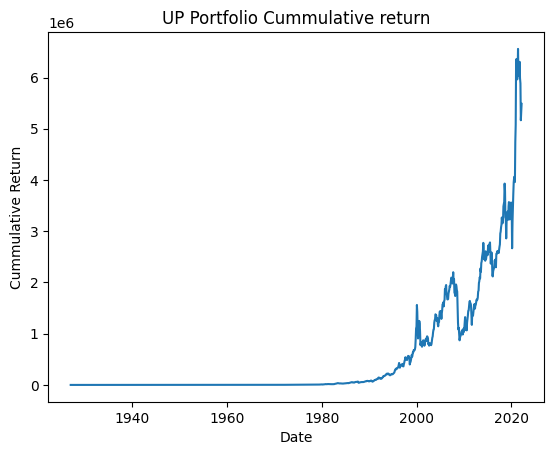

In [84]:
fig = plt.figure()
plt.plot(cummulative_return['UP_ret_f_1m'])
plt.xlabel('Date')
plt.ylabel('Cummulative Return')
plt.title("UP Portfolio Cummulative return")
plt.show();

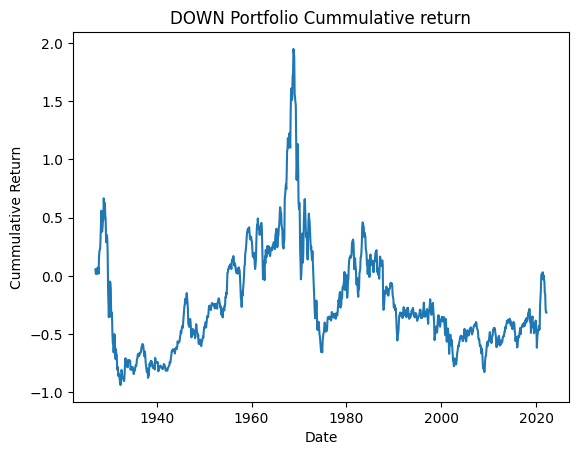

In [85]:
fig = plt.figure()
plt.plot(cummulative_return['DOWN_ret_f_1m'])
plt.xlabel('Date')
plt.ylabel('Cummulative Return')
plt.title("DOWN Portfolio Cummulative return")
plt.show();

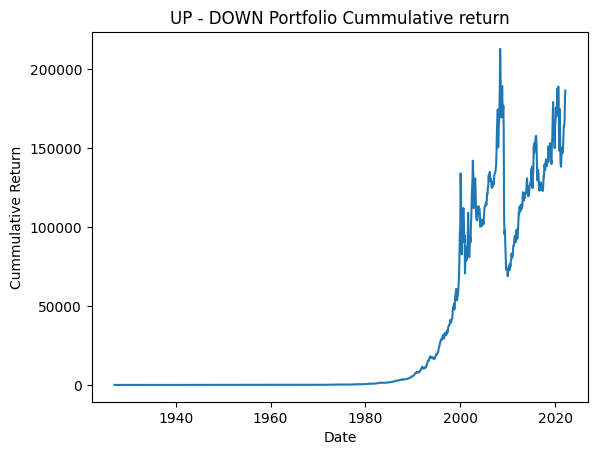

In [86]:
fig = plt.figure()
plt.plot(cummulative_return['UMD_ret_f_1m'])
plt.xlabel('Date')
plt.ylabel('Cummulative Return')
plt.title("UP - DOWN Portfolio Cummulative return")
plt.show();

In [90]:
rolling_3yr_ret = df_monthly_one_month.rolling(36).apply(lambda x : (1+x).prod()-1).dropna()

In [91]:
rolling_3yr_ret

,UP_ret_f_1m,DOWN_ret_f_1m,UMD_ret_f_1m
date,,,
1929-12-31,0.875358,-0.215257,1.265481
1930-01-31,0.909870,-0.232244,1.361628
1930-02-28,1.053515,-0.064803,1.055127
1930-03-31,0.899239,-0.088026,0.948777
1930-04-30,0.690020,-0.167712,0.891274
...,...,...,...
2021-10-29,0.845205,0.403987,0.120028
2021-11-30,1.058291,0.652297,0.070456
2021-12-31,0.620250,0.189258,0.180443
